Importing Packages and Libraries

In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz # used for Fuzzy K Means Clustering
from sklearn.preprocessing import StandardScaler

# Suppress warnings (Local Machine CAN be removed later)
import warnings
warnings.filterwarnings('ignore')
import os 
os.environ['OMP_NUM_THREADS'] = '1'

Load 'Mall_Customers.CSV' Dataset

In [293]:
df = pd.read_csv('Mall_Customers.csv')

Info on the 'Mall_Customers.csv" Data

In [294]:
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("Dataset info:")
print(df.info())

Dataset shape: (200, 5)

First few rows:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
N

Annual Income (k$) and Spending Score (1-100) Chosen Features

StandardScaler Class Used to ensure that data is standardized

In [295]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Finding Optimal_K (Clusters) w/ Fuzzy Partition Coefficient

Tests different cluster numbers (2-10) using FCM validation 

This happens from calcalating FPC for each k value

np.random.seed(42) gives a reproducable result

In [296]:
K = range(2, 11)
fpcs = [] # Fuzzy Partition Coefficient

np.random.seed(42)
for k in K:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_scaled.T, k, 2, error=0.005, maxiter=1000, init=None
    )
    fpcs.append(fpc)

Visul showcases the different FPC score results 

Highest FPC will have the correspodning best option for Optimal_K

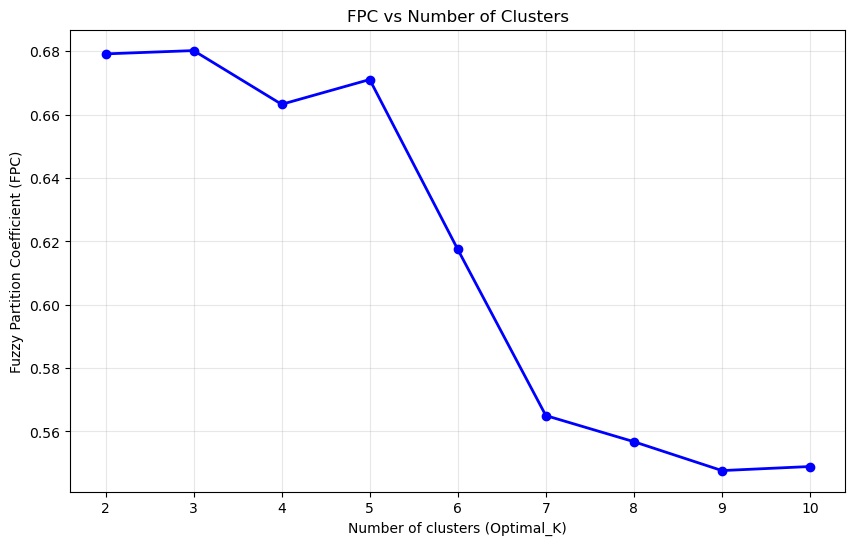

Optimal number of clusters: 3


In [297]:
plt.figure(figsize=(10, 6))
plt.plot(K, fpcs, 'bo-', linewidth=2)
plt.xlabel('Number of clusters (Optimal_K)')
plt.ylabel('Fuzzy Partition Coefficient (FPC)')
plt.title('FPC vs Number of Clusters')
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal k
optimal_k = K[fpcs.index(max(fpcs))]
print(f"Optimal number of clusters: {optimal_k}")

Optimal_K is found from Highest FPC

Using the found Optimal_K to commence Final Clustering

In [298]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_scaled.T, optimal_k, 2, error=0.005, maxiter=1000, init=None
)

Checks for:

Converged Iterations (did NOT hit max iterations)

Final FPC (Highest FPC used to defined Optimal_K)

In [299]:
print(f"Converged in {p} iterations")
print(f"Final FPC: {fpc:.4f}")

Converged in 20 iterations
Final FPC: 0.6802


Visual Showcase of the Final Clustering

Converts fuzzy membership to hard cluster

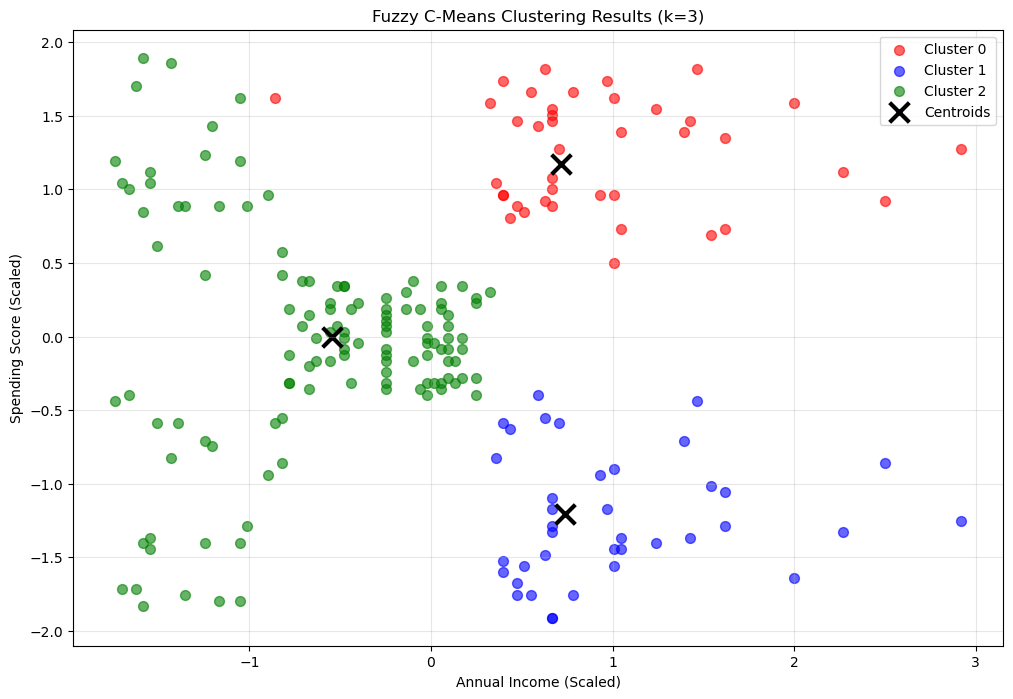

In [300]:
# Convert fuzzy membership to hard clusters for plotting
cluster_membership = np.argmax(u, axis=0)

plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'purple', 'orange']

for i in range(optimal_k):
    cluster_points = X_scaled[cluster_membership == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
               c=colors[i], label=f'Cluster {i}', alpha=0.6, s=50)

plt.scatter(cntr[:, 0], cntr[:, 1], c='black', marker='x', 
           s=200, linewidth=3, label='Centroids')

plt.xlabel('Annual Income (Scaled)')
plt.ylabel('Spending Score (Scaled)')
plt.title('Fuzzy C-Means Clustering Results (k=3)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

First 10 Customer Check

Shows the degree of which cluster the customer belongs to

In [301]:
# Show fuzzy membership for first few customers
print("Fuzzy membership matrix (first 10 customers):")
print("Customer | Cluster 0 | Cluster 1 | Cluster 2")
print("-" * 45)
for i in range(min(10, u.shape[1])):
    print(f"{i+1:8d} | {u[0,i]:9.3f} | {u[1,i]:9.3f} | {u[2,i]:9.3f}")

Fuzzy membership matrix (first 10 customers):
Customer | Cluster 0 | Cluster 1 | Cluster 2
---------------------------------------------
       1 |     0.132 |     0.168 |     0.700
       2 |     0.276 |     0.140 |     0.584
       3 |     0.152 |     0.346 |     0.502
       4 |     0.253 |     0.135 |     0.613
       5 |     0.125 |     0.157 |     0.718
       6 |     0.246 |     0.132 |     0.622
       7 |     0.149 |     0.351 |     0.500
       8 |     0.353 |     0.145 |     0.502
       9 |     0.149 |     0.369 |     0.482
      10 |     0.219 |     0.123 |     0.658


Converts Scaled Data to Original Data

Showcases Each Cluster with Avg Annual Income and Spending Score

In [302]:
# Convert cluster centers back to original scale
cntr_original = scaler.inverse_transform(cntr)
print("\nCluster Centers (Original Scale):")
print("Cluster | Annual Income | Spending Score")
print("-" * 40)
for i in range(optimal_k):
    print(f"{i:7d} | {cntr_original[i,0]:12.1f} | {cntr_original[i,1]:13.1f}")


Cluster Centers (Original Scale):
Cluster | Annual Income | Spending Score
----------------------------------------
      0 |         79.3 |          80.3
      1 |         79.9 |          19.1
      2 |         46.3 |          50.2


Clutser Group Write-Up

Cluster 0: Typically High Income w/ High Spending Customers
Income: $79,300, Spending Score: 80.3

Cluster 1: Typically High Income w/ Low Spending Customers
Income: $79,900, Spending Score: 19.1

Cluster 2: Typically Mid to Low Income w/ Average Spending
Income: $46,300, Spending Score: 50.2
